In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import least_squares


# Parameters

In [20]:
A_min = 1e10 # Bq
A_max = 2e10 # Bq
Ab = 500 # Bq
h = 10 # m
dt = 100 # the pause on each point od the grid in s
x_max = 4 # m
y_max = 4 # m
grid = [8, 8] # m
n_bins = 20

radiation = [A_min, A_max, Ab, dt]
detector = [h, x_max, y_max, grid]

## Flyover

In [61]:
def activity(source, x, y, h):
    u, v, A0 = source[0], source[1], source[2]
    return A0 / ((x - u)**2 + (y - v)**2 + h**2)

def point_source(x_max, y_max, A_min, A_max):
    return [random.uniform(-x_max, x_max), random.uniform(-y_max, y_max), random.uniform(A_min, A_max)]

def flyover(radiation, detector, source = []):
    A_min, A_max, Ab, dt = radiation[0], radiation[1], radiation[2], radiation[3]
    h, x_max, y_max, grid = detector[0], detector[1], detector[2], detector[3]
    N_x, N_y = grid[0], grid[1]
    square_x, square_y = (2*x_max)/N_x, (2*y_max)/N_y 
    xs = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_x))
    ys = np.linspace(-y_max + square_y/2, y_max - square_y/2, int(N_y))
    if len(source) == 0:
        source = point_source(x_max, y_max, A_min, A_max)
    intensities = np.zeros((int(N_x), int(N_y)))
    grid_x, grid_y = np.meshgrid(xs, ys)
    n, m = N_x - 1, 0
    y = -y_max + square_y/2
    i = 1
    max_intensity = {"number": [0], "postion": [[(0, 0), (0, 0)]]}
    for x in xs:
        while abs(y) <= y_max:
            intensity = activity(source, x, y, h) * dt
            if Ab* dt > intensity:
                intensities[n, m] = 0
            else:
                intensities[n, m] = intensity - Ab*dt
            if max_intensity["number"][0] < intensity:
                max_intensity["number"], max_intensity["position"] = [intensity], [[(x - square_x/2, x + square_x/2), (y - square_y/2, y + square_y/2)]]
            elif max_intensity["number"][0] == intensity:
                max_intensity["position"] = [max_intensity["position"][0], [(x - square_x/2, x + square_x/2), (y - square_y/2, y + square_y/2)]]
            y += (square_y)*i
            n -= 1*i
        n += 1*i
        i = i * (-1)
        y += (square_y)*i
        m += 1

    return {"intensities_array": intensities, "source": source, "grid_x": grid_x, "grid_y": grid_y, "hotspot": max_intensity["position"], "square_x": square_x, "square_y": square_y}

measurement = flyover(radiation, detector)

measurement["hotspot"]


[[(-3.0, -2.0), (-1.0, 0.0)]]

## Location from measurement

In [62]:
# Using the Levenberg-Marquardt method

def location(measurement, radiation, detector):
    A_min, A_max, Ab, dt = radiation[0], radiation[1], radiation[2], radiation[3]
    h = detector[0]
    hotspot = measurement["hotspot"]

    # def h(theta, x, y):
    #     return theta[2] * (x - theta[0])**2 + theta[3] * (y - theta[1])**2

    # xs = np.linspace(-1, 1, 20)
    # ys = np.linspace(-1, 1, 20)
    gridx, gridy = measurement["grid_x"], measurement["grid_y"]
    # u = 0.1; v = -0.15; A0 = 2 # ; noise = 0.1
    Is = measurement["intensities_array"]
    # hs += noise * np.random.default_rng().random(hs.shape)

    def fun(source):
        return (activity(source, gridx, gridy, h) * dt - Is).flatten()

    source0 = point_source(x_max, y_max, A_min, A_max)
    res = least_squares(fun, source0)

    return res["x"]

measurement = flyover(radiation, detector)
source = location(measurement, radiation, detector)

# print(source)


### Useful tutorial 

In [48]:
def h(theta, x, y, h):
    return theta[2] * (x - theta[0])**2 + theta[3] * (y - theta[1])**2 - h

xs = np.linspace(-1, 1, 20)
ys = np.linspace(-1, 1, 20)
dt = 10
gridx, gridy = np.meshgrid(xs, ys)
x0 = 0.1; y0 = -0.15; a = 1; b = 2; noise = 0.1
hs = h([x0, y0, a, b], gridx, gridy, 10) * dt
# hs += noise * np.random.default_rng().random(hs.shape)

def fun(theta):
    return (h(theta, gridx, gridy, 10) * dt - hs).flatten()

theta0 = [0, 0, 1, 2]
res3 = least_squares(fun, theta0)

# print(hs)


## Combine

In [63]:
# combines the detector flyover and the location detection
def combination(radiation, detector, source= []):
    measurement = flyover(radiation, detector, source)
    source = location(measurement, radiation, detector)
    MyDict = {'measurement': measurement, 'source_location': source}
    return MyDict


## Visualization

<ipython-input-64-2254f06f0e63>:15: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im)


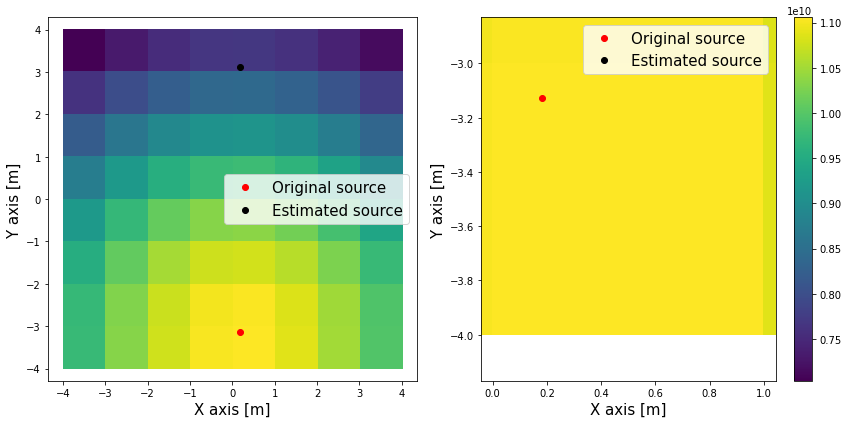

In [64]:
def visualize(measurement, x_max, y_max, points):
    u, v, A0 = points[0], points[1], points[2]

    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
    
    im = ax1.imshow(measurement["intensities_array"], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    # plt.imshow(np.zeros((8, 8)), extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    X, Y = measurement["source"][0], measurement["source"][1]
    ax1.plot(X, Y, "o", color = 'r', label = "Original source")
    ax1.plot(u, v, "o", color = 'k', label = "Estimated source")
    ax1.axis("equal")
    ax1.set_xlabel("X axis [m]", fontsize = 15)
    ax1.set_ylabel("Y axis [m]", fontsize = 15)

    plt.colorbar(im)
   
    ax1.legend(fontsize = 15)
    #plt.grid()

    ax2.imshow(measurement["intensities_array"], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    # plt.imshow(np.zeros((8, 8)), extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    X, Y = measurement["source"][0], measurement["source"][1]
    ax2.plot(X, Y, "o", color = 'r', label = "Original source")
    # ax2.plot(points["point_candidates"][:, 0], points["point_candidates"][:, 1], "o", color = 'g', label = "Estimated sources")
    ax2.plot(u, v, "o", color = 'k', label = "Estimated source")
    ax2.axis("equal")
    ax2.set_xlim(measurement["hotspot"][0][0][0], measurement["hotspot"][0][0][1])
    ax2.set_xlabel("X axis [m]", fontsize = 15)
    ax2.set_ylim(measurement["hotspot"][0][1][0], measurement["hotspot"][0][1][1])
    ax2.set_ylabel("Y axis [m]", fontsize = 15)

   
    ax2.legend(fontsize = 15)
    #plt.grid()
    

    plt.tight_layout()
    # plt.savefig("graphics/imporved.jpg")
    plt.show()
    # return points[1]


data = combination(radiation, detector)

visualize(data["measurement"], detector[1], detector[2], data["source_location"])